In [1]:
!pip install -q opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/seoyunje/gastroscopy-256x256-resized-png')
od.download('https://www.kaggle.com/datasets/msyu78/gastroscopy-meta')

Skipping, found downloaded files in "./gastroscopy-256x256-resized-png" (use force=True to force download)
Skipping, found downloaded files in "./gastroscopy-meta" (use force=True to force download)


## 1. Import Library
___

### Install EfficientDet Library

In [2]:
!pip install -q git+https://github.com/rwightman/efficientdet-pytorch

  Preparing metadata (setup.py) ... done


In [3]:
!pip install -q colorama

In [4]:
import os
import sys
import pickle
import random
import gc
import ctypes
import copy
from collections import defaultdict

from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore
from PIL import Image
import cv2

import torch; import timm
print(f'{Fore.BLUE} => Pytorch Version: ', torch.__version__)
print(f'{Fore.BLUE} => Timm Version: ', timm.__version__)
import torch.nn as nn
from torch.cuda import amp
import torch.functional as F
from torch.utils.data import DataLoader, Dataset

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

## EfficientDet Library
from effdet.efficientdet import EfficientDet, HeadNet, BiFpn
from effdet.bench import DetBenchTrain, DetBenchPredict
# default config: tf_efficientdet_d1
from effdet.config import get_efficientdet_config, default_detection_model_configs
from effdet.config import default_detection_train_config, get_fpn_config

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
import warnings
warnings.filterwarnings('ignore')

print(f'{Fore.BLUE} => Installed Necessary Library')

 => Pytorch Version:  2.5.1+cu124
 => Timm Version:  1.0.14


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.3 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


 => Installed Necessary Library


### Configuration

In [5]:
class CFG:
    output_dir = 'runs/detect'
    seed = 2025

    img_size = [256, 256]
    imgdir = '/content/gastroscopy-256x256-resized-png'
    model_name = 'tf_efficientdet_d0'
    num_classes = 3 # Ulcer, Polyp, Cancer

    num_epochs = 15
    train_bs = 16
    valid_bs = train_bs * 2
    scheduler_type = 'ReduceLROnPlateau' # CosineAnnealingLR, CosineAnnealingWarmRestarts
    base_lr = 1e-4
    min_lr = 1e-12
    weight_decay = 5e-5
    T_mult = 1

    n_accumulate = 1 ## Gradient Accumulation
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device_count = torch.cuda.device_count()

print('Device is', CFG.device)
print('Num GPU of machine is', CFG.device_count)

Device is cuda
Num GPU of machine is 1


### Reproducibility

In [6]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(CFG.seed)

### Clean_memory

In [7]:
def clean_memory():
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()

clean_memory()

## 2. Utils
___

**draw_bbox**

In [8]:
def draw_bbox(image, box, label_name, label_id, color):
    alpha_text = 0.8 # text box color
    thickness = 2
    overlay_bbox = image.copy()
    overlay_text = image.copy()
    output = image.copy()

    text_width, text_height = cv2.getTextSize(str(label_id) + ' ' + label_name.upper(), cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)[0]
    # Adding Text Box
    cv2.rectangle(overlay_text, (box[0],box[1]-text_height-5),
                  (box[0]+text_width, box[1]), color, -1)
    cv2.addWeighted(overlay_text, alpha_text, output, 1-alpha_text, 0, output)
    cv2.rectangle(output, (box[0], box[1]), (box[2],box[3]), color, thickness)
    cv2.putText(output, str(label_id) + ' ' + label_name.upper(), (box[0], box[1]-3),
               cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)

    return output

**AverageMeter**

In [9]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

**Collate_fn**

In [10]:
def collate_fn(batch):
    return tuple(zip(*batch))

## 3. Build Dataset
___

In [11]:
df = pd.read_csv('/content/gastroscopy-meta/gastroscopy_data2.csv')
print('Shape of DataFrame: ', df.shape)
print(display(df))

Shape of DataFrame:  (2915, 14)


,image_id,height,width,organ,lesion_label,location,shape_type_polygon,polygon_mask,bounding_box_shape,x_min,y_min,x_max,y_max,lesion
0,1_1_00011.png,2048,2048,gastroscopy,0,1,polygon,"1257.45,738.30;1212.77,748.94;1168.09,748.94;1...",rectangle,763.829787,365.957447,1304.255319,748.936170,ulcer
1,1_1_00011.png,2048,2048,gastroscopy,0,1,polygon,"1421.28,955.32;1387.23,985.11;1368.09,1025.53;...",rectangle,1148.936170,897.872340,1421.276596,1082.978723,ulcer
2,1_1_00014.png,2048,2048,gastroscopy,0,1,polygon,"1065.96,1110.64;1040.43,1148.94;1010.64,1182.9...",rectangle,521.276596,561.702128,1078.723404,1225.531915,ulcer
3,1_1_00017.png,2048,2048,gastroscopy,0,1,polygon,"1246.30,514.89;1197.36,508.51;1154.81,502.13;1...",rectangle,884.595745,502.127660,1376.085106,753.191489,ulcer
4,1_1_00018.png,2048,2048,gastroscopy,0,1,polygon,"1397.36,389.36;1352.68,382.98;1314.38,404.26;1...",rectangle,1161.191489,382.978723,1654.808511,1074.468085,ulcer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2910,1_2_05234.png,2048,2048,gastroscopy,1,1,polygon,"1115.23,604.26;1066.30,604.26;1021.62,608.51;9...",rectangle,864.170213,604.255319,1506.723404,1340.425532,polyp
2911,1_2_05235.png,2048,2048,gastroscopy,1,1,polygon,"1138.64,1036.17;1096.09,1068.09;1064.17,1102.1...",rectangle,949.276596,1019.148936,1528.000000,1542.553191,polyp
2912,1_2_05236.png,2048,2048,gastroscopy,1,1,polygon,"619.49,529.79;583.32,555.32;553.53,591.49;532....",rectangle,523.744681,519.148936,766.297872,789.361702,polyp
2913,1_2_05236.png,2048,2048,gastroscopy,1,1,polygon,"672.68,1342.55;630.13,1355.32;606.72,1393.62;6...",rectangle,602.468085,1342.553191,759.914894,1493.617021,polyp


None


In [12]:
## 궤양(Ulcer): 1
## 용종(Polyp): 2
## 암(Cancer): 3


df['lesion_label'] = df['lesion_label'] + 1

In [13]:
train_id = [x.split('/')[-1] for x in glob('/content/gastroscopy-256x256-resized-png/train/*.png')]
test_id = [x.split('/')[-1] for x in glob('/content/gastroscopy-256x256-resized-png/test/*.png')]

train_df = df[df['image_id'].isin(train_id)].reset_index(drop=True)
test_df = df[df['image_id'].isin(test_id)].reset_index(drop=True)

print('=> Number of Unique Image_id in Train: ', train_df.image_id.nunique())
print('=> Number of Unique Image_id in Test: ', test_df.image_id.nunique())

=> Number of Unique Image_id in Train:  1597
=> Number of Unique Image_id in Test:  400


In [14]:
gkf = GroupKFold(n_splits=5)

for i, (_, val_idx) in enumerate(gkf.split(train_df, groups=train_df['image_id'])):
    train_df.loc[val_idx, 'fold'] = i

valid_df = train_df[train_df['fold'] == 0].reset_index(drop=True)
train_df = train_df[train_df['fold'] != 0].reset_index(drop=True)

print('Images in train_df: ', train_df['image_id'].nunique())
print('Images in valid_df: ', valid_df['image_id'].nunique())

Images in train_df:  1279
Images in valid_df:  318


In [15]:
def get_train_transform():
    return A.Compose(
        [A.HorizontalFlip(p=0.5),
         A.Resize(*CFG.img_size, p=1.0),
         ToTensorV2(p=1.0),],
         bbox_params = A.BboxParams(format='pascal_voc', label_fields=['labels'])
    )

def get_valid_transform():
    return A.Compose(
        [A.Resize(*CFG.img_size, p=1.0),
         ToTensorV2(p=1.0),],
        bbox_params = A.BboxParams(format='pascal_voc', label_fields=['labels'])
    )

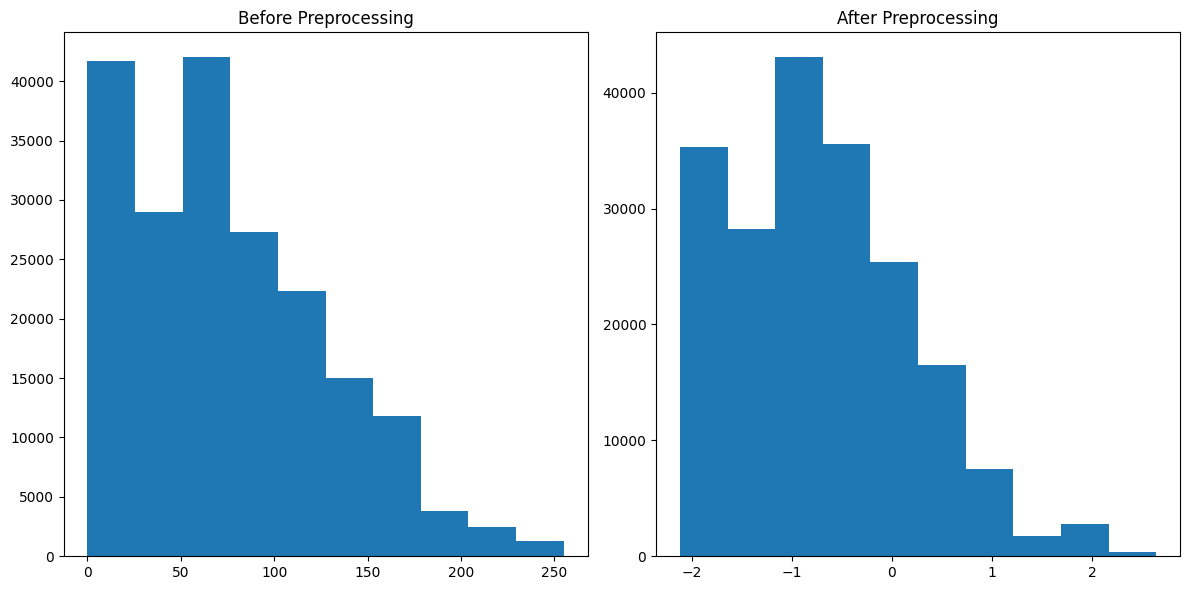

In [16]:
!pip install -q efficientnet

from efficientnet.keras import preprocess_input

path = '/content/gastroscopy-256x256-resized-png/train/1_1_00011.png'
img = Image.open(path)
img = np.array(img)
img_preprocessed = preprocess_input(img)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Before Preprocessing')
plt.hist(img.flatten())

plt.subplot(1,2,2)
plt.title('After Preprocessing')
plt.hist(img_preprocessed.flatten())

plt.tight_layout()
plt.show()

In [17]:
### Bbox Format: Ymin, Xmin, Ymax, Xmax
### Image Preprocessing: Normalization

class GastroscopyDataset(Dataset):
    def __init__(self, df, image_dir=None, mode='train', transforms=None):
        super(GastroscopyDataset).__init__()

        self.image_ids = df['image_id'].unique()
        self.df = df
        self.mode = mode
        self.image_dir = image_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, index):
        image_id = self.image_ids[index]

        image, boxes, labels = self.load_image_and_boxes(image_id)

        target= {}
        target['boxes'] = torch.tensor(boxes).to(torch.float32)
        target['labels'] = torch.tensor(labels).to(torch.int64)
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            sample = self.transforms(image=image, bboxes=boxes, labels=labels)

            if len(sample['bboxes']) > 0:
                image = sample['image']
                target['boxes'] = torch.tensor(sample['bboxes']).to(torch.float32)
                target['labels'] = torch.tensor(sample['labels']).to(torch.int64)
                # Xmin, Ymin, Xmax, Ymax => Ymin, Xmin, Ymax, Xmax
                target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]

        return image, target, image_id

    def load_image_and_boxes(self, image_id):
        path = os.path.join(f'{self.image_dir}', self.mode, image_id)
        image = Image.open(path)
        image = np.array(image)
        resized_height, resized_width = image.shape[:2]

        ## FillNan
        m = np.nanmean(image)
        image = np.nan_to_num(image, nan=m)

        ## Preprocessing
        #mean = np.array([0.485, 0.456, 0.406])
        #std = np.array([0.229, 0.224, 0.225])
        #image /= 255.0
        #image = (image - mean) / std
        image = preprocess_input(image).astype('float32')

        records = self.df[self.df['image_id'] == image_id]
        boxes = records[['x_min','y_min','x_max','y_max']].values
        boxes[:,[0,2]] *= resized_width / records['width'].values[0]
        boxes[:,[1,3]] *= resized_height / records['height'].values[0]

        labels = records['lesion_label'].values

        return image, boxes, labels

In [18]:
train_dataset = GastroscopyDataset(
         df = train_df,
         image_dir = CFG.imgdir,
         transforms = get_train_transform()
)

valid_dataset = GastroscopyDataset(
         df = valid_df,
         image_dir = CFG.imgdir,
         transforms = get_valid_transform()
)

## 3. Visualization Gastroscopy Augmentation
___

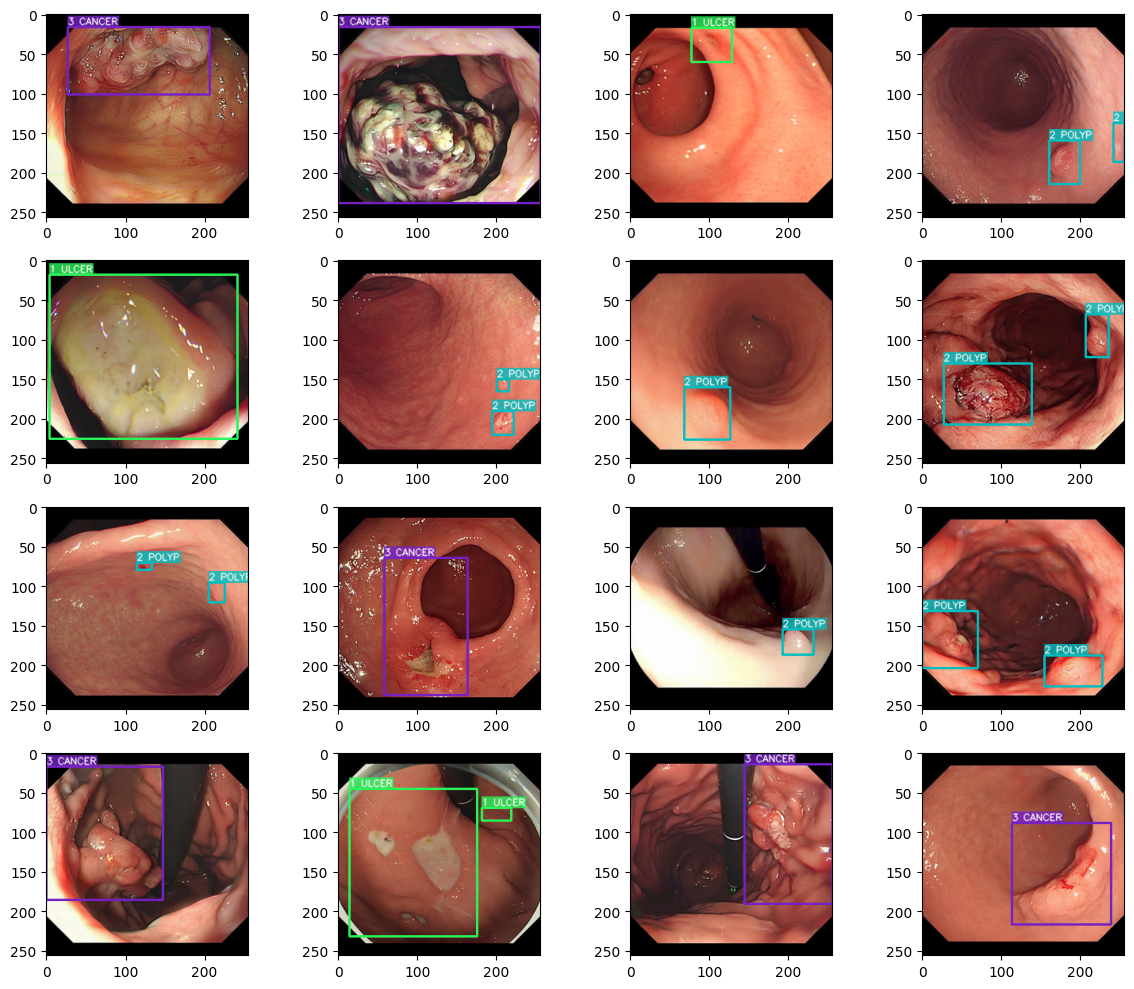

In [19]:
classes = {1: 'Ulcer', 2: 'Polyp', 3: 'Cancer'}

label2color = [[random.randint(0,255) for i in range(3)] for _ in range(CFG.num_classes)]

plt.figure(figsize=(12,10))

for i in range(16):
    j = np.random.randint(0, len(train_dataset), 1)[0]
    image, target, image_id = train_dataset[j]
    img = image.permute(1,2,0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img*std + mean

    img = (img*255).astype('uint8')
    boxes = target['boxes'].cpu().numpy()
    boxes[:,[0,1,2,3]] = boxes[:,[1,0,3,2]]
    labels = target['labels'].cpu().numpy()

    plt.subplot(4,4,i+1)
    for label_id, box in zip(labels, boxes):
        color = label2color[label_id - 1]
        img = draw_bbox(img, list(np.int_(box)), classes[label_id], label_id, color)
        plt.imshow(img)
        #plt.axis('off')
    clean_memory()
    del image, target, image_id

plt.tight_layout()
plt.show()

## 4. Build Trainer Engine
___

**Scheduler**

In [20]:
def fetch_scheduler(scheduler_type, optimizer, loader):
    if scheduler_type == 'ReduceLROnPlateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', verbose=False, factor=0.1, patience=5, threshold=1e-3,
            threshold_mode='abs', min_lr = CFG.min_lr
        )
        return scheduler

    elif scheduler_type == 'CosineAnnealingLR':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=CFG.num_epochs*len(loader), eta_min=CFG.min_lr,
            last_epoch=-1, verbose=False
        )
        return scheduler

    elif scheduler_type == 'CosineAnnealingWarmRestarts':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0 = CFG.num_epochs*len(loader)//3, T_mult=CFG.T_mult, eta_min=CFG.min_lr,
            last_epoch=-1, verbose=False
        )
        return scheduler

    else:
        return None

**Build_model**

In [21]:
def build_model():
    config = get_efficientdet_config(model_name=CFG.model_name)
    config.num_classes = CFG.num_classes
    config.image_size = CFG.img_size

    net = EfficientDet(config, pretrained_backbone=True)
    net.box_net = HeadNet(config, num_outputs=4)
    net.class_net= HeadNet(config, num_outputs=config.num_classes)

    return DetBenchTrain(net, create_labeler=True)

In [22]:
class Trainer:
    def __init__(self, model, optimizer, scheduler, device, num_epochs, output_dir):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.num_epochs = num_epochs

        self.history = defaultdict(list)
        self.best_loss = 10**5
        self.best_epoch = 0

        self.output_dir = output_dir

        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir, exist_ok=True)

        print(f'{Fore.BLUE} ### Trainer Prepared, Device is {self.device}')

    def fit(self, train_loader, valid_loader):

        for epoch in range(1, self.num_epochs + 1):
            print(f'{Fore.BLUE}#'*25)
            print(f'{Fore.BLUE}### Epoch {epoch}/{self.num_epochs}')
            print(f'{Fore.BLUE}#'*25)

            train_loss = self.train_one_epoch(train_loader)
            valid_loss = self.valid_one_epoch(valid_loader)

            print(f'{Fore.BLUE}Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}')

            last_model_wts = copy.deepcopy(self.model.state_dict())
            torch.save(last_model_wts, f'{self.output_dir}/last-checkpoint.bin')

            if valid_loss <= self.best_loss:
                self.best_loss = valid_loss
                self.best_epoch = epoch
                best_model_wts = copy.deepcopy(self.model.state_dict())

                torch.save(best_model_wts, f'{self.output_dir}/best-checkpoint.bin')

            self.model.load_state_dict(torch.load(f'{self.output_dir}/best-checkpoint.bin'))

        return self.model, self.history


    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        box_loss = AverageMeter()
        class_loss = AverageMeter()
        scaler = amp.GradScaler()

        pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc='Training')

        for step, (images, targets, image_ids) in pbar:
            images = torch.stack(images) ## Adding Batch Dimensional
            images = images.to(self.device).float()
            batch_size = images.size(0)

            target_res = {}
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            target_res['bbox'] = boxes
            target_res['cls'] = labels

            output = self.model(images, target_res)

            loss = output['loss']; summary_loss.update(loss.detach().item(), batch_size)
            cls_loss = output['class_loss']; class_loss.update(cls_loss.detach().item(), batch_size)
            bx_loss = output['box_loss']; box_loss.update(bx_loss.detach().item(), batch_size)


            (loss / CFG.n_accumulate).backward()

            if (step + 1) % CFG.n_accumulate == 0:

               self.optimizer.step()

               self.optimizer.zero_grad()

               if CFG.scheduler_type == 'ReduceLROnPlateau':
                   self.scheduler.step(metrics=summary_loss.avg)
               else:
                   self.scheduler.step()

            mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0

            self.history['summary_loss'].append(summary_loss.avg)
            self.history['box_loss'].append(box_loss.avg)
            self.history['class_loss'].append(class_loss.avg)

            pbar.set_postfix(
                  total_loss = f'{summary_loss.avg:.5f}',
                  cls_loss = f'{class_loss.avg:.5f}',
                  box_loss = f'{box_loss.avg:.5f}',
                  lr = f'{self.optimizer.param_groups[0]["lr"]:.5f}',
                  gpu_mem = f'{mem} GB'
             )

        torch.cuda.empty_cache()
        clean_memory()

        return summary_loss.avg

    @torch.no_grad()
    def valid_one_epoch(self, valid_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        box_loss = AverageMeter()
        class_loss = AverageMeter()

        pbar = tqdm(enumerate(valid_loader), total=len(valid_loader), desc='Validation')
        for step, (images, targets, image_ids) in pbar:
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.size(0)

                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                target_res = {}
                target_res['bbox'] = boxes
                target_res['cls'] = labels
                target_res['img_scale'] = torch.tensor([1.0]*batch_size,
                                                       dtype=torch.float).to(self.device)
                target_res['img_size'] = torch.tensor([images[0].shape[-2:]]*batch_size,
                                                       dtype=torch.float).to(self.device)
                output = self.model(images, target_res)
                loss = output['loss']; summary_loss.update(loss.detach().item(), batch_size)
                cls_loss = output['class_loss']; class_loss.update(cls_loss.detach().item(), batch_size)
                bx_loss = output['box_loss']; box_loss.update(bx_loss.detach().item(), batch_size)

                mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0

                self.history['valid_summary_loss'].append(summary_loss.avg)
                self.history['valid_box_loss'].append(box_loss.avg)
                self.history['valid_class_loss'].append(class_loss.avg)

                pbar.set_postfix(
                     valid_total_loss = f'{summary_loss.avg:.5f}',
                     valid_cls_loss = f'{class_loss.avg:.5f}',
                     valid_box_loss = f'{box_loss.avg:.5f}',
                     lr = f'{self.optimizer.param_groups[0]["lr"]:.5f}',
                     gpu_mem = f'{mem} GB'
                )

        torch.cuda.empty_cache()
        clean_memory()

        return summary_loss.avg



In [23]:
def run_training():

    train_loader = DataLoader(
        train_dataset,
        batch_size = CFG.train_bs,
        shuffle = True,
        drop_last = False,
        pin_memory = True,
        collate_fn = collate_fn,
    )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size = CFG.valid_bs,
        shuffle = False,
        drop_last = False,
        pin_memory = True,
        collate_fn = collate_fn
    )

    model = build_model()
    model.to(CFG.device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.base_lr, weight_decay=CFG.weight_decay)
    scheduler = fetch_scheduler(CFG.scheduler_type, optimizer, train_loader)

    trainer = Trainer(model=model, optimizer=optimizer, scheduler=scheduler,
            device=CFG.device, num_epochs=CFG.num_epochs, output_dir=CFG.output_dir)

    best_model, history = trainer.fit(train_loader, valid_loader)

    del train_loader, valid_loader
    clean_memory()

    return best_model, history


In [ ]:
best_model, history = run_training()

 ### Trainer Prepared, Device is cuda
#########################
### Epoch 1/15
#########################


Validation: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s, gpu_mem=0.956301312 GB, lr=0.00000, valid_box_loss=0.01320, valid_cls_loss=237.00667, valid_total_loss=237.66645]


Train Loss: 216.4699 | Valid Loss: 237.6664
#########################
### Epoch 2/15
#########################


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s, gpu_mem=0.983564288 GB, lr=0.00000, valid_box_loss=0.01321, valid_cls_loss=236.01878, valid_total_loss=236.67951]


Train Loss: 217.1804 | Valid Loss: 236.6795
#########################
### Epoch 3/15
#########################


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s, gpu_mem=0.98566144 GB, lr=0.00000, valid_box_loss=0.01329, valid_cls_loss=234.93821, valid_total_loss=235.60265]


Train Loss: 216.8452 | Valid Loss: 235.6026
#########################
### Epoch 4/15
#########################


Training:  10%|█         | 8/80 [00:03<00:34,  2.07it/s, box_loss=0.02131, cls_loss=225.70897, gpu_mem=2.5690112 GB, lr=0.00000, total_loss=226.77434]